# Testing the PyFreatboard API

**PyFreatboard** was intended to have a simple way to draw freatboard diagrams (aka shapes) using Python. Most of the available solutions use SVG as the graphics engine while I wanted something based on Matplotlib.

## Defining a shape

Shapes (or diagrams) are composed of Fingers. Therefore, there is a 
* `Finger` class to define a finger position, harmonic function, fingering, ... and 
* a `Shape` class that contains a set of fingers.

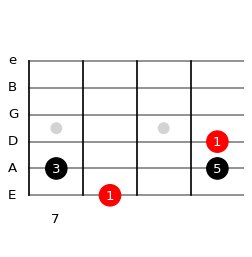

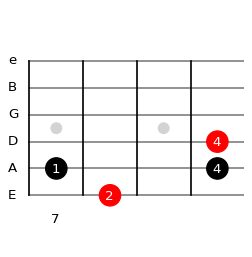

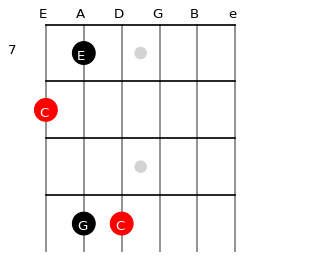

In [1]:
from PyFreatboard.finger import Finger
from PyFreatboard.shape import Shape
from PyFreatboard.draw_freatboard import DrawFreatboard

f1 = Finger(semitone=Finger.NOTES['C'], function='1', string='E', freat=8, finger='2')
f2 = Finger(semitone=Finger.NOTES['E'], function='3', string='A', freat=7, finger='1')
f3 = Finger(semitone=Finger.NOTES['G'], function='5', string='A', freat=10, finger='4')
f4 = Finger(semitone=Finger.NOTES['C'], function='1', string='D', freat=10, finger='4')
c_shape = Shape([f1, f2, f3, f4])

# Draw diagram showing harmonic function
draw = DrawFreatboard()
f = draw.draw_shape(c_shape, text=DrawFreatboard.TEXT_FUNCTION, return_fig=True)
f.savefig('shape.png', bbox_inches='tight')

# Draw diagram showing fingering
draw.draw_shape(c_shape, text=DrawFreatboard.TEXT_FINGER)

# Draw diagram showing Note name in vertical--> WARNING! Notes are show using enharmony! 
draw_v = DrawFreatboard(freat_size=15) # For vertical diagrams it is better reduce freat_size from 20 to 15
draw_v.draw_shape_vertical(c_shape, text=DrawFreatboard.TEXT_NOTE, show_string_names=True) # In vertical mode string names are by default disables


## Automatic shape generation

Since defining the *fingers* one by one is tedious, there is a `BuildShape` class that can generate them automatically.

The class follows the following steps:

* Given a root and a shape type (defined in the `shapes.csv` file), it generates all shape notes.
* Finds at which position on the freatboard these notes can be played.
* Recursively, all sets of shapes are generated in which the lower freat and the upper freat are within six or less of each other.
* An automatic fingering algorithm is used to assign with which finger to play each note.
* The resulting shapes are filtered using various heuristics to keep only the most playable shapes.

With the current fingering and filtering rules, the algorithm can generate the standard *Berklee* shapes plus some additional shapes that are variants of them. By modifying these rules, other shapes/fingerings could be created.

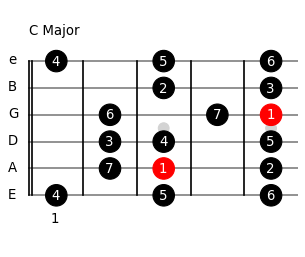

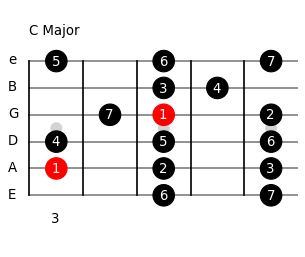

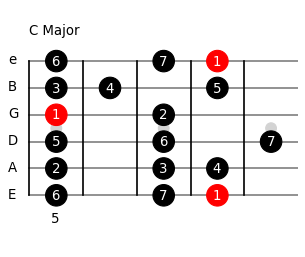

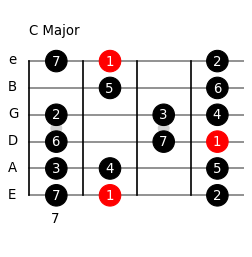

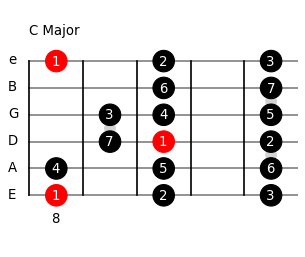

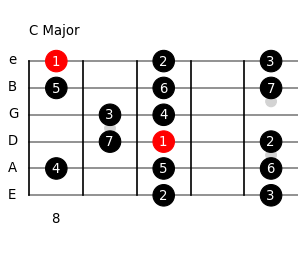

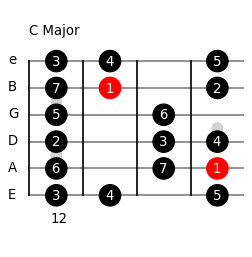

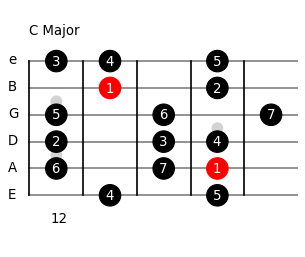

In [1]:
from PyFreatboard.build_shape import BuildShape
from PyFreatboard.draw_freatboard import DrawFreatboard

c_major = BuildShape(root='C', shape_type='Major', plot_type=DrawFreatboard.TEXT_FINGER)
draw = DrawFreatboard()

for shape in c_major.all_shapes:
    if shape.valid:
        draw.draw_shape(shape, text=DrawFreatboard.TEXT_FUNCTION, shape_name="C Major")
        


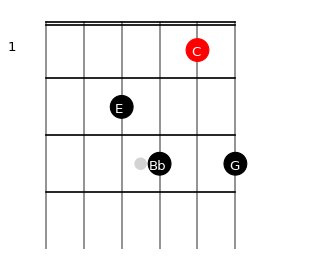

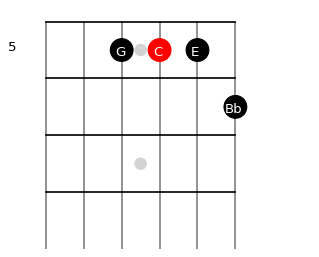

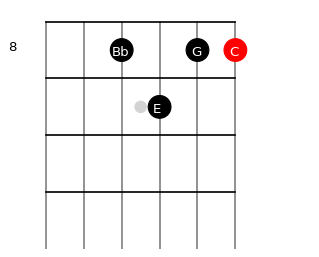

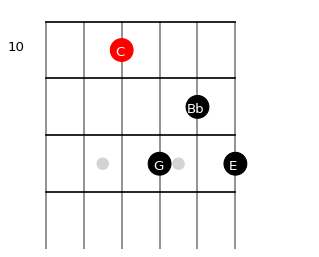

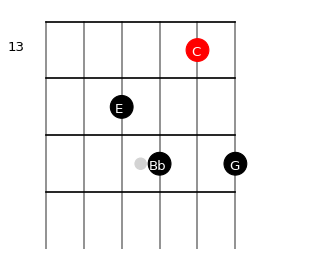

In [3]:
from PyFreatboard.build_shape import BuildShape
from PyFreatboard.draw_freatboard import DrawFreatboard

c7_drop2 = BuildShape(root='C', shape_type='7')
drops = c7_drop2.build_drop(drop=2, bass_string="D")
draw = DrawFreatboard(freat_size=15)
for d in drops:
    if d.valid:
        draw.draw_shape_vertical(d, text=DrawFreatboard.TEXT_NOTE)


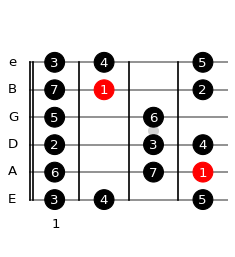

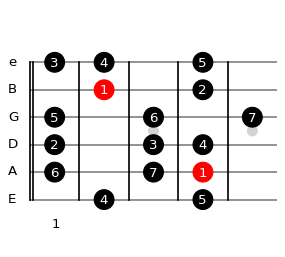

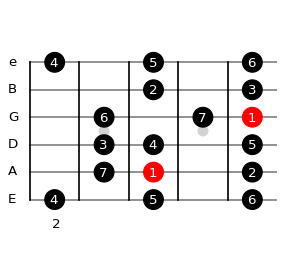

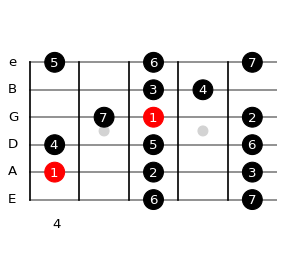

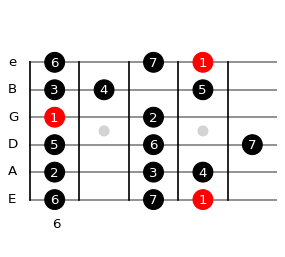

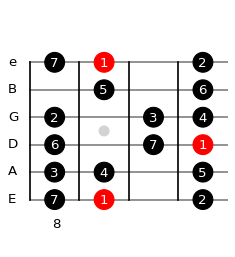

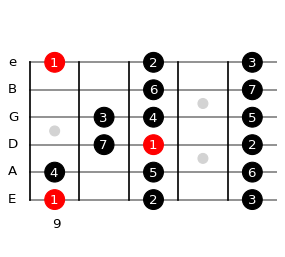

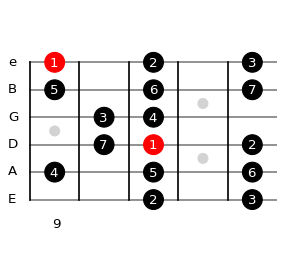

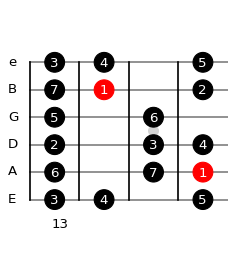

In [23]:
# Blue Bossa

from PyFreatboard.build_shape import BuildShape
from PyFreatboard.draw_freatboard import DrawFreatboard

shape = BuildShape(root='C#', shape_type='Ionian')
draw = DrawFreatboard(freat_size=18)
for s in shape.all_shapes:
    if s.valid:
        draw.draw_shape(s, text=DrawFreatboard.TEXT_FUNCTION)

Autumn Leaves by Jonny Mercer
- G Major: A-7 (4), D7 (4), GMaj7 (4), CMaj7 (4)
- E Minor: F#-7b5 (4), B7 (4), E-7 (8)


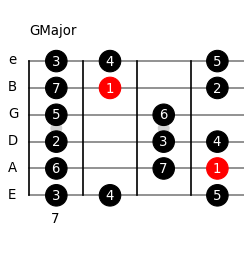

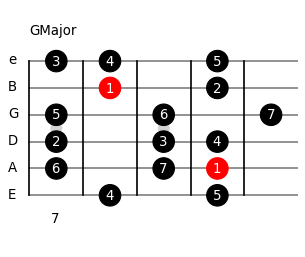

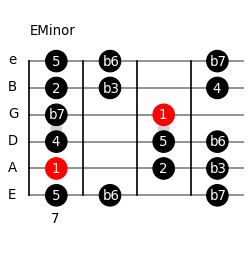

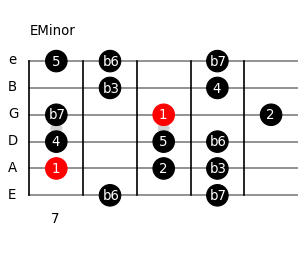

In [1]:
from PyFreatboard.song import Song
song = Song("/home/narcis/PyFreatboard/autumn_leaves.xml")
print(song)
melody = song.get_melody("main")
# for note in melody:
#     print(note)
Song.draw_shapes(song.get_drops2(), 7)